# Setup

In [ ]:
import os
import numpy as np
import pandas as pd
path = input("Enter the path:")
from google.colab import drive
drive.mount('/content/drive/')
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train = pd.read_csv("train.csv")

In [ ]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
train.shape

(54808, 14)

# Variable identification

In [ ]:
train.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

is_promoted is the target variable in this case

In [ ]:
# For getting data types of dataframes
def get_dtypes(df):
  num_cols = list(train.select_dtypes(exclude = 'object').columns)
  cat_cols = [column for column in df.columns if column not in num_cols]
  
  return num_cols,cat_cols

In [ ]:
num_cols, cat_cols = get_dtypes(train)

There might be a few numeric variables in binary form or having a fixed number of values. These can be converted into categorical variables.

In [ ]:
for i in range(0,len(num_cols)):
    print(str(num_cols[i]) + " - Number of Unique Values: " + str(train[num_cols[i]].nunique()))

employee_id - Number of Unique Values: 54808
no_of_trainings - Number of Unique Values: 10
age - Number of Unique Values: 41
previous_year_rating - Number of Unique Values: 5
length_of_service - Number of Unique Values: 35
avg_training_score - Number of Unique Values: 61


KPIs_met >80%, awards_won? and is_promoted have only 2 unique values, these can be converted into categorical variables. 

In [ ]:
def convert_to_categorical(df,col):
  return df[col].apply(lambda x:str(x)) 

In [ ]:
train['KPIs_met >80%'] = convert_to_categorical(train,'KPIs_met >80%')
train['awards_won?'] = convert_to_categorical(train,'awards_won?')
train['is_promoted'] = convert_to_categorical(train,'is_promoted')

In [ ]:
train.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%            object
awards_won?              object
avg_training_score        int64
is_promoted              object
dtype: object

In [ ]:
num_cols, cat_cols = get_dtypes(train)

In [ ]:
#since id number won't be helpful for any analysis
num_cols.remove('employee_id')

# Target variable exploration

The target variable is_promoted is a categorical variable with 2 outputs. Thus, this is a binary classification problem.

In [ ]:
train['is_promoted'].value_counts(normalize=True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

Since there is a huge difference between % values for both classes, this is an imbalanced class problem

# Univariate analysis

## Numeric variables

In [ ]:
num_cols

['no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'avg_training_score']

In [ ]:
def plot_numerical(df_col):
  fig, axes = plt.subplots(nrows =1 , ncols=2, figsize=(12, 6))
  fig.tight_layout()
  ax1,ax2 = axes[0] , axes[1]  
  sns.boxplot(df_col, orient='vertical',ax=ax1)
  sns.distplot(df_col, kde = False, bins = 20, ax = ax2)
  plt.show()

For column name:  no_of_trainings


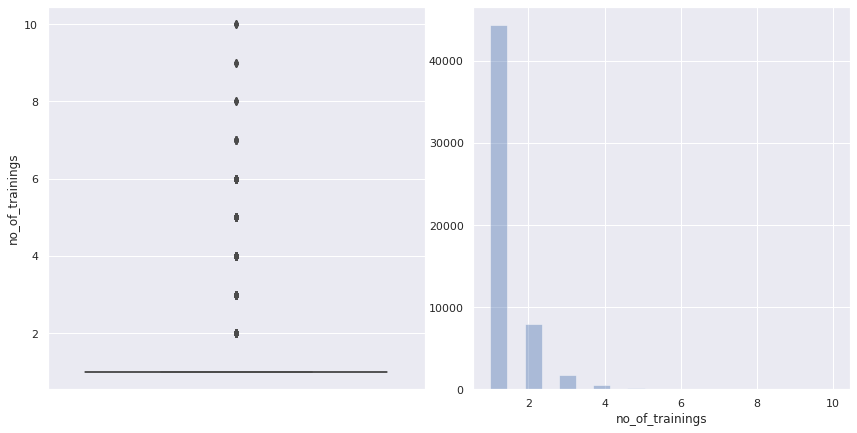

---------------------------------
For column name:  age


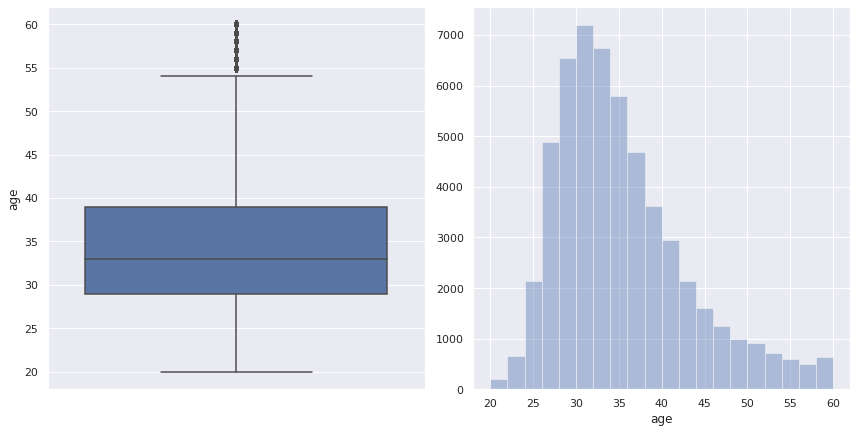

---------------------------------
For column name:  previous_year_rating


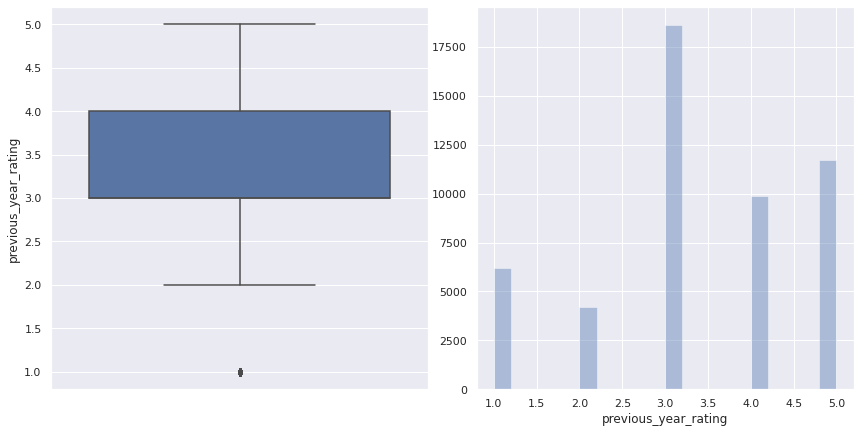

---------------------------------
For column name:  length_of_service


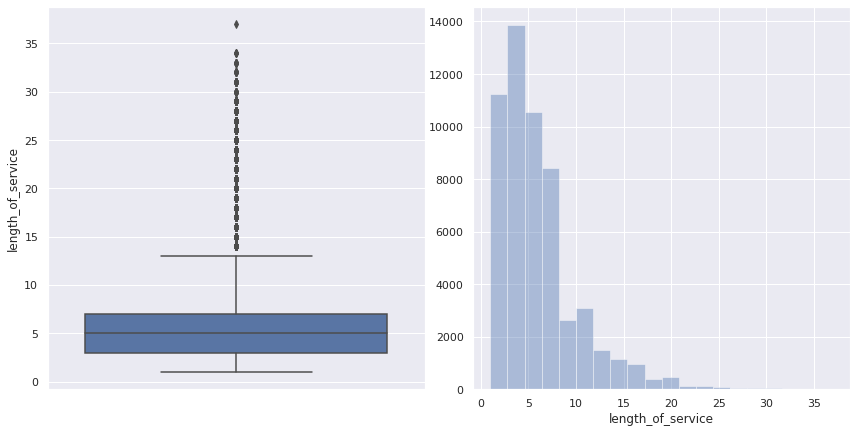

---------------------------------
For column name:  avg_training_score


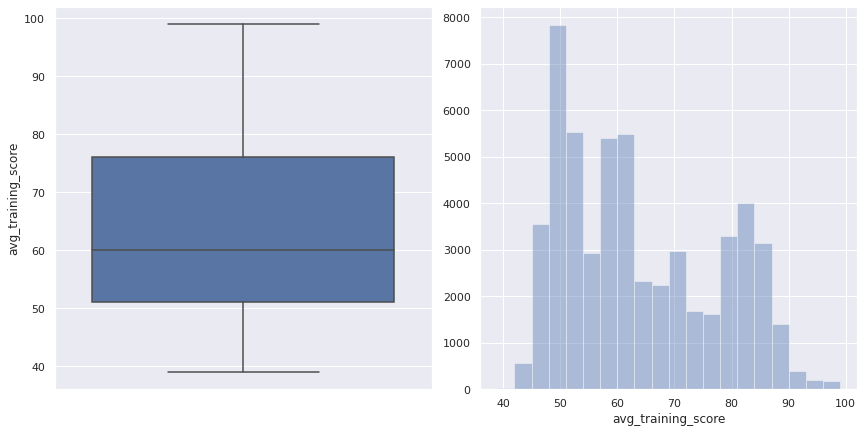

---------------------------------


In [ ]:
for col in num_cols:
  print("For column name: ",col)
  plot_numerical(train[col])
  print("---------------------------------")

From the above plots, we can infer the following for each variable

1. no_of_trainings: Maximum number of employees have completed only 1 training. This can be converted into a categorical variable,  is_multiple_training_completed. 

2. Age: The curve is a bit right skewed, with majority of employees in their 30's

3. Previous year training: Majority of employees have a rating of 3. The distribution is somewhat normal.

4. length_of_service: It's a right skewed distribution, with very few people having greater than 10 years of experience

5. avg_training_score: Almost all employees have a score greater than 40. Majority of employees have scores between 50-80, with a few exceptions who scored excellent scores(75+).

In [ ]:
train['no_of_trainings'] = convert_to_categorical(train,'no_of_trainings')

In [ ]:
train['no_of_trainings'].value_counts()

1     44378
2      7987
3      1776
4       468
5       128
6        44
7        12
8         5
10        5
9         5
Name: no_of_trainings, dtype: int64

In [ ]:
temp = []
no_rows = train.shape[0]
print(no_rows)
for i in range(0, no_rows):
  if int(train['no_of_trainings'][i]) > 1:
    temp.append(1)
  else:
    temp.append(0)
  
#is_multiple_training_completed
train['is_multiple_training_completed'] = pd.Series(temp).astype('object')
print(train['is_multiple_training_completed'].value_counts())

54808
0    44378
1    10430
Name: is_multiple_training_completed, dtype: int64


In [ ]:
num_cols.remove('no_of_trainings')
cat_cols.append('is_multiple_training_completed')

## Categorical variables

In [ ]:
for i in range(0,len(cat_cols)):
    print(str(cat_cols[i]) + " - Number of Unique Values: " + str(train[cat_cols[i]].nunique()))

department - Number of Unique Values: 9
region - Number of Unique Values: 34
education - Number of Unique Values: 3
gender - Number of Unique Values: 2
recruitment_channel - Number of Unique Values: 3
KPIs_met >80% - Number of Unique Values: 2
awards_won? - Number of Unique Values: 2
is_promoted - Number of Unique Values: 2
is_multiple_training_completed - Number of Unique Values: 2


In [ ]:
# remove is_promoted since it's target variable
cat_cols.remove('is_promoted')

In [ ]:
def plot_categorical(df,col):
  print("Column name: ",col)
  print(df[col].value_counts(normalize=True) * 100)
  sns.countplot(df[col])
  plt.show()

Column name:  department
Sales & Marketing    30.725442
Operations           20.705007
Procurement          13.023646
Technology           13.023646
Analytics             9.764998
Finance               4.627062
HR                    4.411765
Legal                 1.895709
R&D                   1.822727
Name: department, dtype: float64


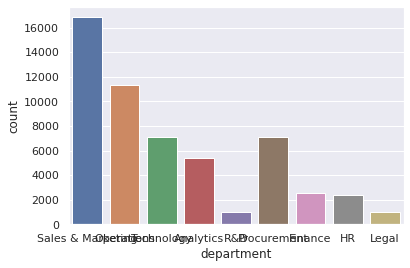

Column name:  region
region_2     22.520435
region_22    11.728215
region_7      8.836301
region_15     5.123340
region_13     4.831411
region_26     4.123486
region_31     3.530506
region_4      3.107211
region_27     3.026930
region_16     2.672967
region_28     2.404758
region_11     2.399285
region_23     2.143848
region_29     1.813604
region_32     1.724201
region_19     1.594658
region_20     1.550868
region_14     1.508904
region_25     1.494307
region_17     1.452343
region_5      1.397606
region_6      1.258940
region_30     1.198730
region_8      1.195081
region_10     1.182309
region_1      1.112976
region_24     0.926872
region_12     0.912276
region_9      0.766311
region_21     0.749891
region_3      0.631295
region_34     0.532769
region_33     0.490804
region_18     0.056561
Name: region, dtype: float64


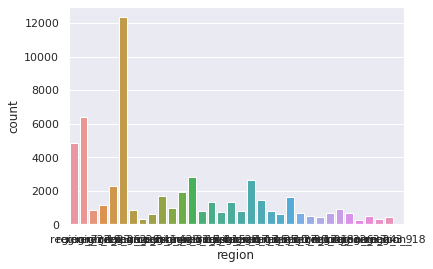

Column name:  education
Bachelor's          69.980343
Master's & above    28.483368
Below Secondary      1.536289
Name: education, dtype: float64


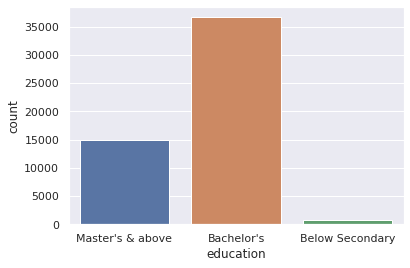

Column name:  gender
m    70.237921
f    29.762079
Name: gender, dtype: float64


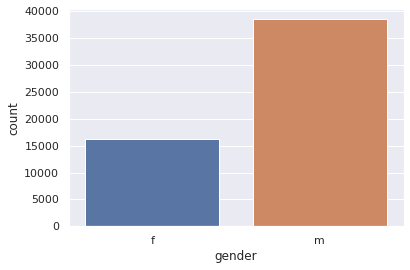

Column name:  recruitment_channel
other       55.550285
sourcing    42.366078
referred     2.083637
Name: recruitment_channel, dtype: float64


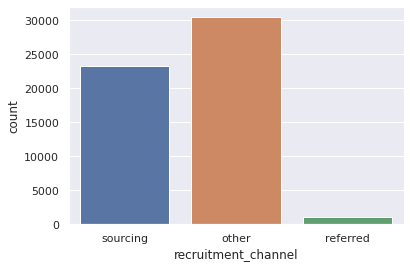

Column name:  KPIs_met >80%
0    64.802584
1    35.197416
Name: KPIs_met >80%, dtype: float64


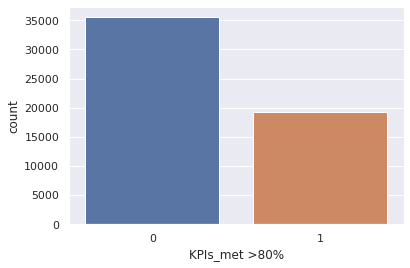

Column name:  awards_won?
0    97.68282
1     2.31718
Name: awards_won?, dtype: float64


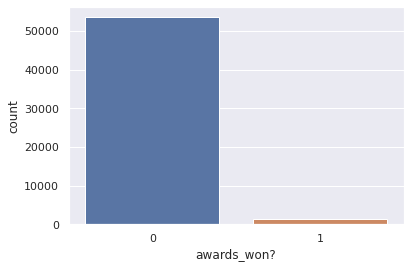

Column name:  is_multiple_training_completed
0    80.969931
1    19.030069
Name: is_multiple_training_completed, dtype: float64


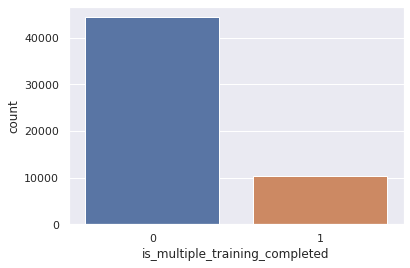

In [ ]:
for col in cat_cols:
  plot_categorical(train,col)

In [ ]:
train.drop(['no_of_trainings'],axis=1,inplace=True)

# Bivariate analysis
We will now compare various attributes to the target is_promoted variables in order to gain further insights of various factors affecting promotions

## Categorical Variable - Categorical Target plot

In [ ]:
color = sns.color_palette()

In [ ]:
def barplot_percentages(df,feature,target):
    ax1 = df.groupby(feature)[target].value_counts(normalize=True).unstack() * 100
    print(ax1)
    ax1.plot(kind='bar', stacked='True')
    int_level = df[feature].value_counts()

    plt.figure(figsize=(8,4))
    sns.barplot(int_level.index, int_level.values, alpha=0.8, color=color[1])
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(str(feature), fontsize=12)
    plt.show()

## We can divide the independent attributes into 3 types:

1. Work based: department,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?
2. Training based: avg_training_score,is_multiple_training_completed
3. Demography based: region,education,gender,recruitment_channel,age

In [ ]:
train.dtypes

employee_id                         int64
department                         object
region                             object
education                          object
gender                             object
recruitment_channel                object
age                                 int64
previous_year_rating              float64
length_of_service                   int64
KPIs_met >80%                      object
awards_won?                        object
avg_training_score                  int64
is_promoted                        object
is_multiple_training_completed     object
dtype: object

In [ ]:
work_attr = ['department','previous_year_rating','length_of_service','KPIs_met >80%','awards_won?']
train_attr = ['avg_training_score','is_multiple_training_completed']
dem_attr = ['region','education','gender','recruitment_channel','age']
target = 'is_promoted'

In [ ]:
work_num_cols, work_cat_cols = get_dtypes(train[work_attr])
train_num_cols, train_cat_cols = get_dtypes(train[train_attr])
dem_num_cols, dem_cat_cols = get_dtypes(train[dem_attr])


## Work based attributes

In [ ]:
work_num_cols

['employee_id',
 'age',
 'previous_year_rating',
 'length_of_service',
 'avg_training_score']

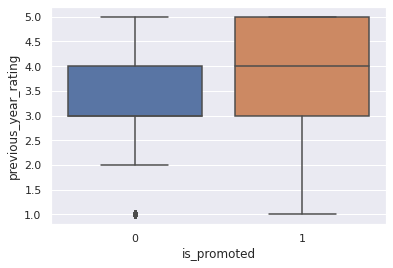

In [ ]:
ax = sns.boxplot(x=target, y='previous_year_rating', data=train)

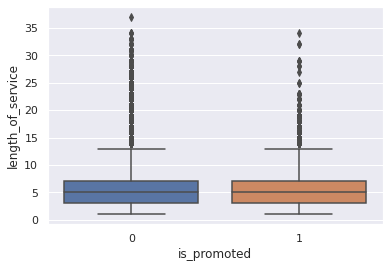

In [ ]:
ax = sns.boxplot(x=target, y='length_of_service', data=train)

Let's perform binning for length_of_service variable and gather some insights. From univariate analysis done earlier we can see that huge number of employees have experience of less than 10 years. Hence there will be a single category for >=10 years experience and many categories for people below 10 yrs experience

In [ ]:
# We will perform binning for age and add it to demographic categorical columns list, where we'll gain insight 
bins = [-1,2,5,7,10,train['length_of_service'].max()]
labels = ['0-2','3-5','5-7','8-10','>10']
train['length_of_service_binned'] = pd.cut(train['length_of_service'], bins,labels=labels)
train['length_of_service_binned'].value_counts()
work_cat_cols.append('length_of_service_binned')

department
is_promoted                0          1
department                             
Analytics          90.433483   9.566517
Finance            91.876972   8.123028
HR                 94.375517   5.624483
Legal              94.898941   5.101059
Operations         90.985196   9.014804
Procurement        90.361446   9.638554
R&D                93.093093   6.906907
Sales & Marketing  92.796912   7.203088
Technology         89.240684  10.759316


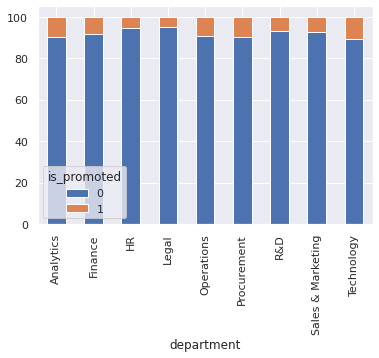

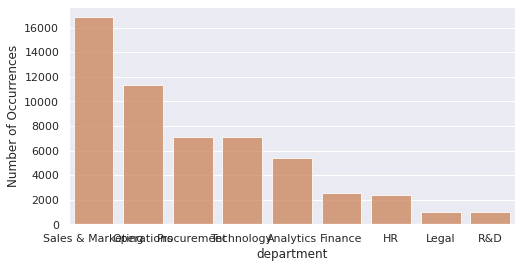

---------------------------------
KPIs_met >80%
is_promoted            0          1
KPIs_met >80%                      
0              96.041332   3.958668
1              83.090560  16.909440


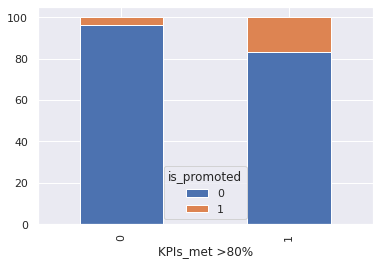

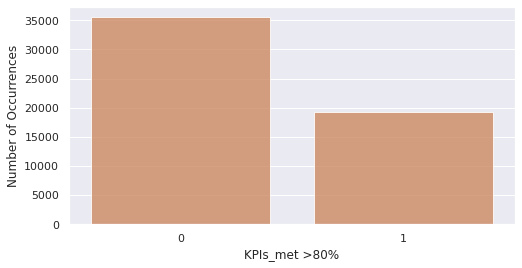

---------------------------------
awards_won?
is_promoted          0          1
awards_won?                      
0            92.325078   7.674922
1            55.984252  44.015748


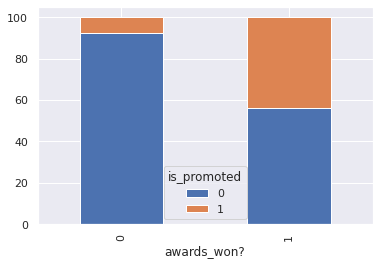

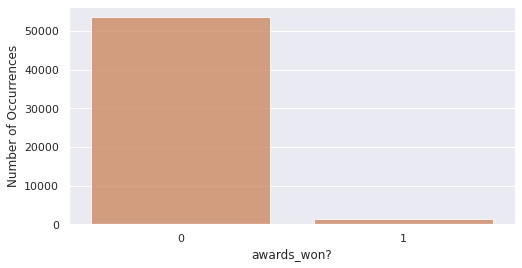

---------------------------------
length_of_service_binned
is_promoted                       0         1
length_of_service_binned                     
0-2                       91.345383  8.654617
3-5                       91.462362  8.537638
5-7                       91.589694  8.410306
8-10                      90.889033  9.110967
>10                       92.405708  7.594292


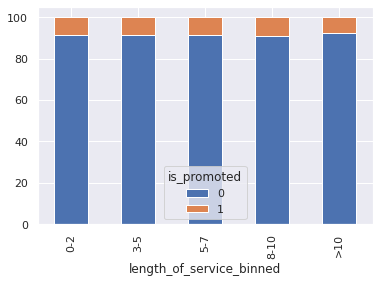

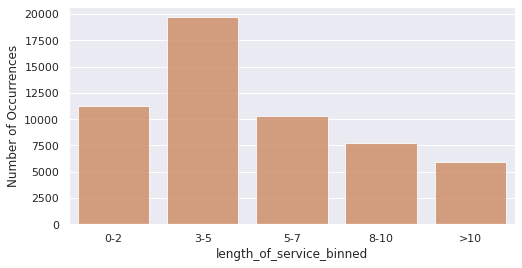

---------------------------------


In [ ]:
for col in work_cat_cols:
  print(col)
  barplot_percentages(train,col,target)
  print("---------------------------------")

Let's check the following
1.  how many % of people who complete >80% kpi's get promoted.
2. how many % of people who won awards got promoted

KPIs_met >80%          0          1
is_promoted                        
0              68.031512  31.968488
1              30.119966  69.880034


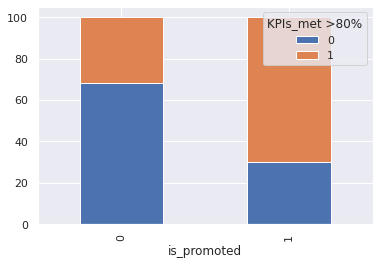

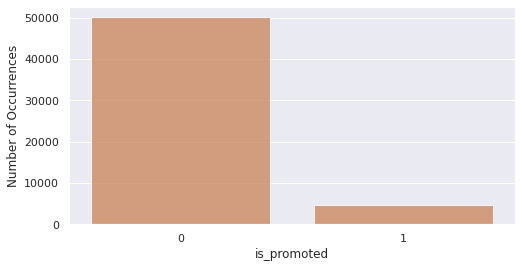

In [ ]:
barplot_percentages(train,target,'KPIs_met >80%')

awards_won?         0         1
is_promoted                    
0            98.58197   1.41803
1            88.02485  11.97515


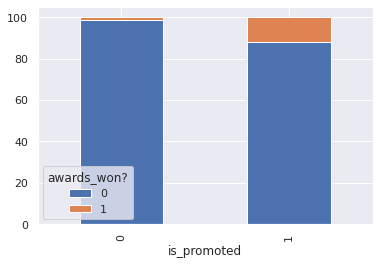

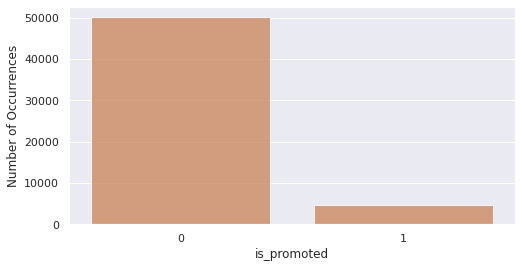

In [ ]:
barplot_percentages(train,target,'awards_won?')

## Train based attributes

In [ ]:
train_num_cols

['employee_id',
 'age',
 'previous_year_rating',
 'length_of_service',
 'avg_training_score']

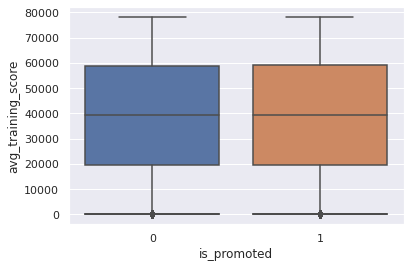

In [ ]:
 for col in train_num_cols:
  ax = sns.boxplot(x=target, y=col, data=train)

is_multiple_training_completed
is_promoted                             0         1
is_multiple_training_completed                     
0                               91.189328  8.810672
1                               92.732502  7.267498


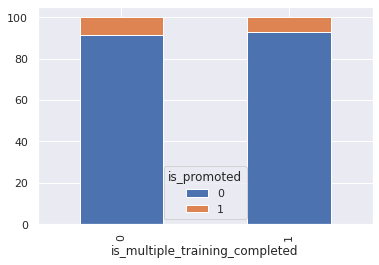

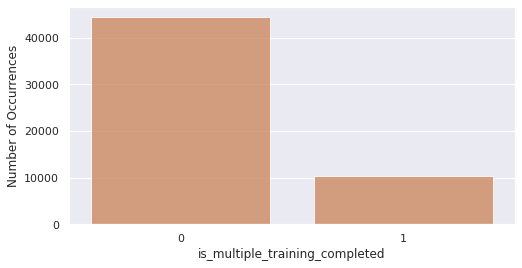

---------------------------------


In [ ]:
for col in train_cat_cols:
  print(col)
  barplot_percentages(train,col,target)
  print("---------------------------------")

## Demographic attributes

In [ ]:
dem_num_cols, dem_cat_cols

(['employee_id',
  'age',
  'previous_year_rating',
  'length_of_service',
  'avg_training_score'],
 ['region', 'education', 'gender', 'recruitment_channel'])

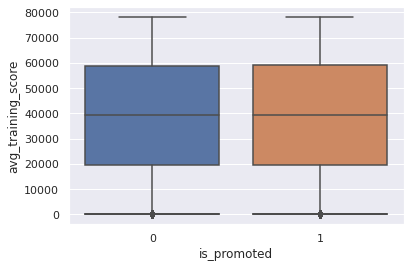

In [ ]:
for col in dem_num_cols:
  ax = sns.boxplot(x=target, y=col, data=train)

Let's perform binning for age variable and gather some insights

In [ ]:
# We will perform binning for age and add it to demographic categorical columns list, where we'll gain insight 
bins = [-1, 29, 39, 49,train['age'].max()]
labels = ['<30','30-39','40-49','>=50']
train['age_binned'] = pd.cut(train['age'], bins,labels=labels)
print(train['age_binned'].value_counts())
dem_cat_cols.append('age_binned')

30-39    28030
<30      14453
40-49     8952
>=50      3373
Name: age_binned, dtype: int64


For demographic categorical variables

region
is_promoted          0          1
region                           
region_1     90.491803   9.508197
region_10    92.129630   7.870370
region_11    94.372624   5.627376
region_12    93.400000   6.600000
region_13    91.314199   8.685801
region_14    92.503023   7.496977
region_15    92.094017   7.905983
region_16    93.037543   6.962457
region_17    86.306533  13.693467
region_18    96.774194   3.225806
region_19    93.935927   6.064073
region_2     91.987361   8.012639
region_20    94.235294   5.764706
region_21    95.620438   4.379562
region_22    88.581207  11.418793
region_23    88.340426  11.659574
region_24    96.456693   3.543307
region_25    87.423687  12.576313
region_26    93.672566   6.327434
region_27    92.103677   7.896323
region_28    88.315630  11.684370
region_29    95.674044   4.325956
region_3     89.306358  10.693642
region_30    91.019787   8.980213
region_31    94.315245   5.684755
region_32    95.767196   4.232804
region_33    96.282528   3.717472
region_

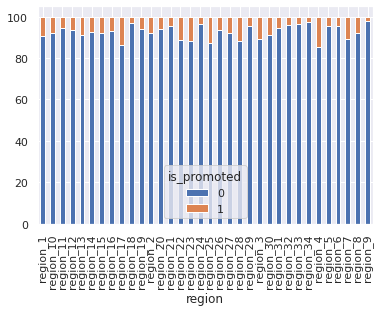

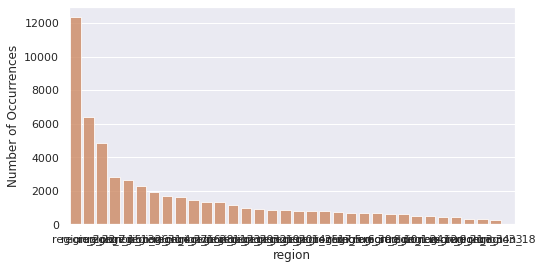

---------------------------------
education
is_promoted               0         1
education                            
Bachelor's        91.796886  8.203114
Below Secondary   91.677019  8.322981
Master's & above  90.144054  9.855946


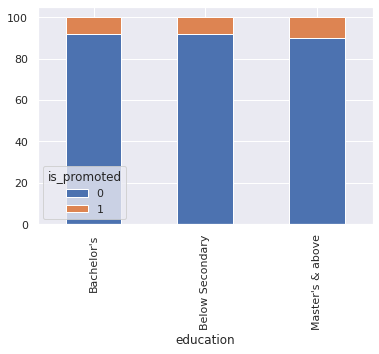

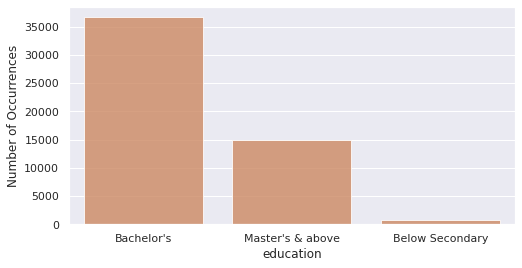

---------------------------------
gender
is_promoted          0         1
gender                          
f            91.006621  8.993379
m            91.684850  8.315150


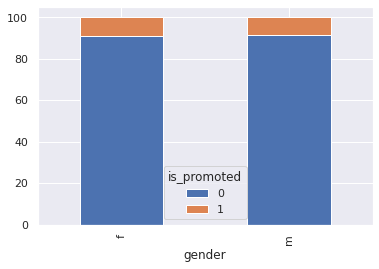

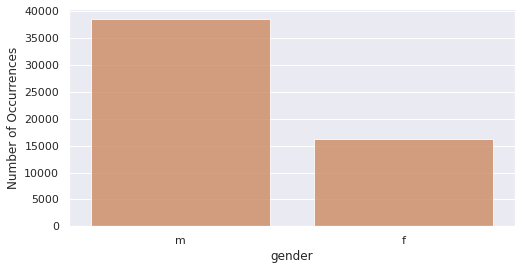

---------------------------------
recruitment_channel
is_promoted                  0          1
recruitment_channel                      
other                91.604809   8.395191
referred             87.915937  12.084063
sourcing             91.498708   8.501292


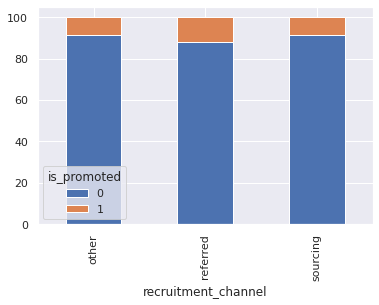

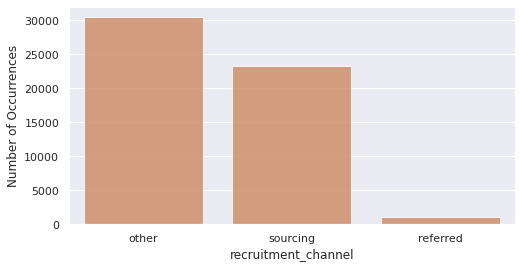

---------------------------------
age_binned
is_promoted          0         1
age_binned                      
<30          91.517332  8.482668
30-39        90.881199  9.118801
40-49        92.582663  7.417337
>=50         93.418322  6.581678


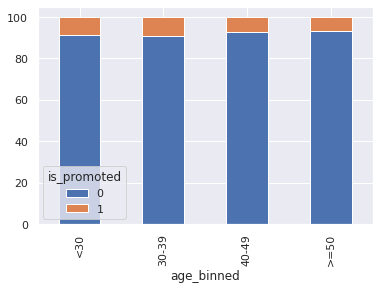

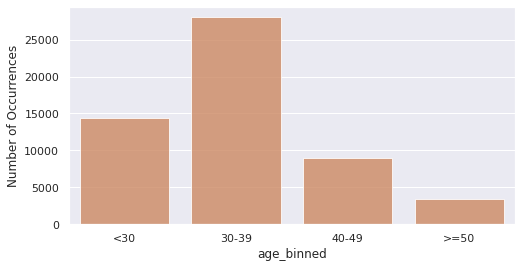

---------------------------------


In [ ]:
for col in dem_cat_cols:
  print(col)
  barplot_percentages(train,col,target)
  print("---------------------------------")

education    Bachelor's  Below Secondary  Master's & above
is_promoted                                               
0             70.342507         1.542223         28.115270
1             66.168060         1.473823         32.358117


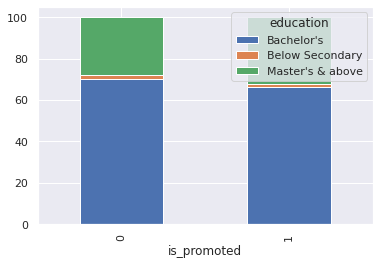

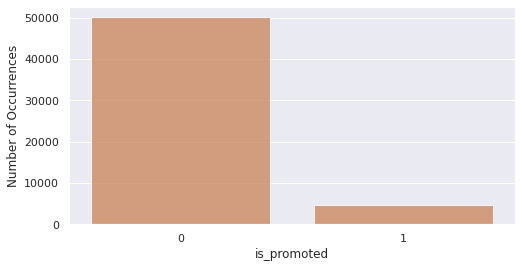

gender               f          m
is_promoted                      
0            29.607100  70.392900
1            31.426735  68.573265


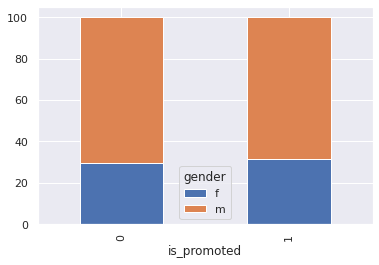

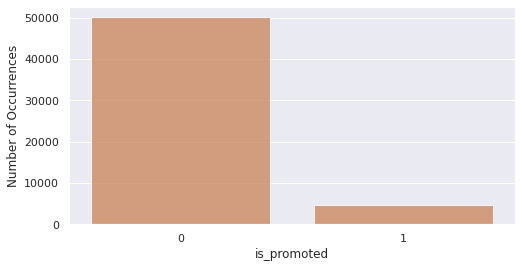

recruitment_channel      other  referred   sourcing
is_promoted                                        
0                    55.624252  2.002393  42.373355
1                    54.755784  2.956298  42.287918


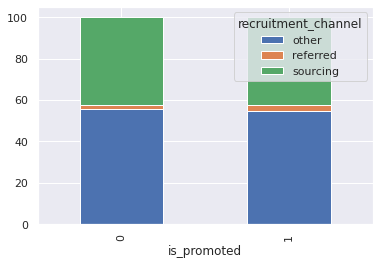

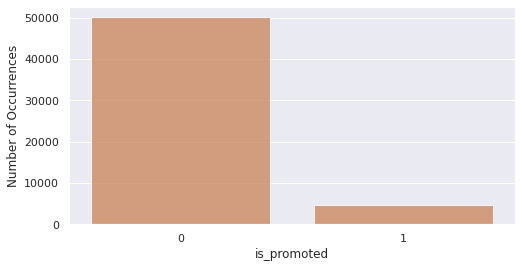

In [ ]:
for col in ['education', 'gender', 'recruitment_channel']:
  barplot_percentages(train,target,col)

Text(0.5, 0, 'gender')

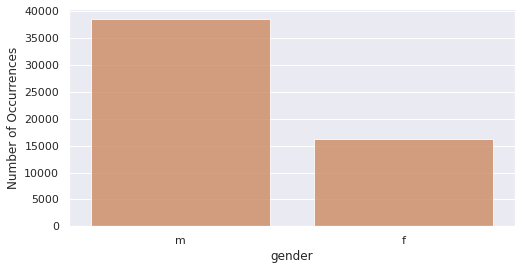

In [ ]:
int_level = train['gender'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(int_level.index, int_level.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel(str('gender'), fontsize=12)

# Co-relation heatmap

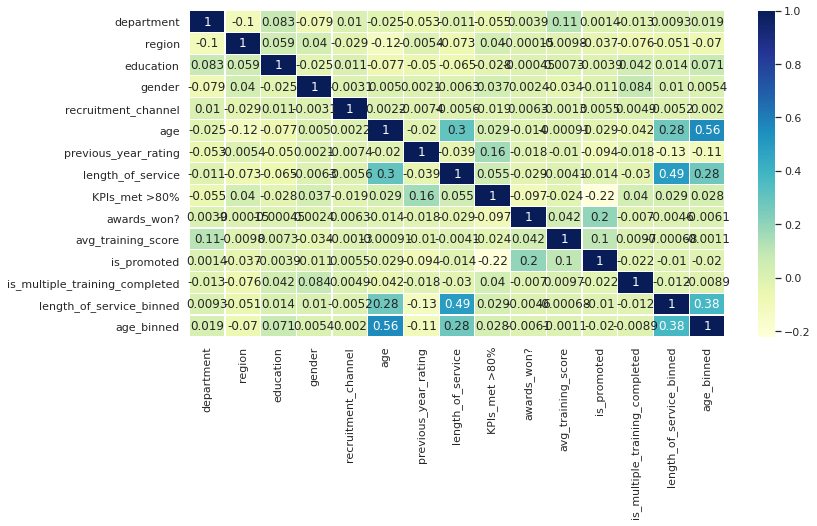

In [ ]:
plt.figure(figsize=(12, 6))
df = train.drop(['employee_id'],axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu",annot=True)

# Summary of Bivariate analysis with target variable is_promoted

1. Previous_year_rating: Higher the rating, better the chances of getting promoted. As a rule of thumb, the majority of employees with rating>4.0 get promoted, while those below 3 don’t. A large number of employees having ratings between 3.0 and 4.0 are present in both categories, which means other factors also play a key role in their promotion.

2. Length_of_service: Similar distributions for both categories. This factor may not be much helpful. On binning we can see that promotion rates are slightly higher for employees having 8-10 years of experience and slightly lower for employees with 10+ years of experience. While there's no difference in promotion rates for employees having <8 years of experience

3. Department: The promotion rate is higher than average (8.5) in technology(> 10%, which is excellent),procurement,analytics and operations departments. The promotion rates are relatively lower in other departments and very poor (below 6%), in HR and legal departments.

4. KPIs_met >80%: 17% of employees promoted had met > 80% KPI’s and only around 4% of employees who didn’t get promoted had met > 80% KPI’s, suggesting that this could be a factor in determining promotions. Around 70% of employees promoted have met > 80% KPI’s, while only 30% of employees who met > 80% KPI’s did not get promoted. While the ratio is vice-versa for employees who didn’t get promoted.

5. Awards_won?: 44% of employees promoted have won an award, whereas only 7% of employees who didn’t win an award got promoted. Around 12% of employees who won awards got promoted, but a meagre 1.4% of employees who didn’t win an award got promoted.

6. Avg_training_score: employees with above 75% training score are almost certain to be promoted, while those below 60% are certain to not be promoted. While a large amount of employees scoring between 60-75% are present in both categories, indicating other factors are considered for these employees

7. Is_multiple_training_completed: Completing multiple training might not be as helpful in getting that promotion, since only around 7.2% of people who complete multiple training get promoted, while 8.8% of people who didn’t complete multiple training still got promoted.

8. Age: There isn’t much difference between the 2 distributions, except for maybe a few people between 35-40. On binning however, we can see that employees 
<40 years of age have a better shot at promotion than employees >40 years of age. The distribution shows a clear difference in terms of % of employees promoted in an age group.

9. Gender: Around 8.3% of men got promoted, while 9% of females did. Around 70% of people promoted were men, but 68.6% of people not promoted were also men. Thus, we might not get much insight from this variable except that the majority of employees in the company are men.

10. Recruitment_channel: It seems like employees that entered the company through referrals, are more likely to get promoted. Around 12% of people who came through referral got promoted, compared to 8.5%(around actual average) through sourcing and 8.4% through other sources.  It is to be noted though that a tiny minority of people come via referrals and bulk of employees have joined the company through sourcing or other recruitment channels.

11. Region: employees from region_17,region_22,region_23,region_25,region_28,region_3,region_4 and region_7 have a higher rate of promotion. We can merge some regions, i.e merging sparse classes, since a vast majority of employees belong to specific regions.

12. Education: People with a masters degree and above have been promoted at a greater rate, around 9.8%, while people having bachelors or below are more or less promoted at the same rate. Very few people have below secondary level education and the majority of employees have a bachelors. 

# Hypothesis Testing

In [ ]:
train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted', 'is_multiple_training_completed',
       'length_of_service_binned', 'age_binned'],
      dtype='object')

In [ ]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

## For categorical variables

In [ ]:
def chi_square(column,target):
  table = pd.crosstab(train[column],train[target],margins=True)
  table.drop('All',axis=1,inplace=True)
  table.drop('All',axis=0,inplace=True)
  stat, p, dof, expected = chi2_contingency(table)
  print('dof=%d' % dof)
  print("Expected \n",expected)
  print("Observed \n",table)

  # interpret test-statistic
  prob = 0.95
  critical = chi2.ppf(prob, dof)
  print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
  if abs(stat) >= critical:
    print('Dependent (reject Null Hypothesis)')
  else:
    print('Independent (fail to reject Null Hypothesis)')
  # interpret p-value
  alpha = 1.0 - prob
  print('significance=%.3f, p=%.3f' % (alpha, p))
  if p <= alpha:
    print('Dependent (reject Null Hypothesis)')
  else:
    print('Independent (fail to reject Null Hypothesis)')

### 1. KPI > 80%.

Null Hypothesis: Having KPI's > 80% makes no difference for promotion 

Alternate Hypothesis: Having KPI's > 80% makes a significant difference for promotion 

In [ ]:
column = "KPIs_met >80%"
target = "is_promoted"
chi_square(column,target)

dof=1
Expected 
 [[32492.01539921  3024.98460079]
 [17647.98460079  1643.01539921]]
Observed 
 is_promoted        0     1
KPIs_met >80%             
0              34111  1406
1              16029  3262
probability=0.950, critical=3.841, stat=2689.322
Dependent (reject Null Hypothesis)
significance=0.050, p=0.000
Dependent (reject Null Hypothesis)


### 2. Is multiple training completed
Null : Completing multiple trainings doesn't affect promotion

Alternate: Completing multiple trainings has an affect on promotion

In [ ]:
column = "is_multiple_training_completed"
target = "is_promoted"
chi_square(column,target)

dof=1
Expected 
 [[40598.32360239  3779.67639761]
 [ 9541.67639761   888.32360239]]
Observed 
 is_promoted                         0     1
is_multiple_training_completed             
0                               40468  3910
1                                9672   758
probability=0.950, critical=3.841, stat=25.614
Dependent (reject Null Hypothesis)
significance=0.050, p=0.000
Dependent (reject Null Hypothesis)


### 3. Education
Null Hypothesis: Degrees have no impact on promotion

Alternate Hypothesis: Degrees have an impact on promotion 

In [ ]:
column = "education"
target = "is_promoted"
chi_square(column,target)

dof=2
Expected 
 [[33487.69360102  3181.30639898]
 [  735.1603084     69.8396916 ]
 [13630.14609057  1294.85390943]]
Observed 
 is_promoted           0     1
education                    
Bachelor's        33661  3008
Below Secondary     738    67
Master's & above  13454  1471
probability=0.950, critical=5.991, stat=36.703
Dependent (reject Null Hypothesis)
significance=0.050, p=0.000
Dependent (reject Null Hypothesis)


## For numeric variables
Reference: https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce

Our Hypothesis for numeric variables are:
### 1. Age
Null Hypothesis: Age doesn't impact promotions

Altenate Hypothesis: Age impacts promotions.

### 2. Previous Year Ratings:
Null Hypothesis: Previous Year ratings have no impact on promotion

Alternate Hypothesis: Previous Year ratings has an impact on promotion



### 3. Avg training score
Null Hypothesis: Avg training score has no impact on promotion

Alternate Hypothesis: Avg training score matters for promotion 




In [ ]:
#Creating a new dataframe containing only the required columns
num_data = train[['age', 'previous_year_rating', 'avg_training_score','is_promoted']]

In [ ]:
from scipy import stats
from statsmodels.stats import weightstats as stests

In [ ]:
columns = list(num_data.columns)
columns.remove('is_promoted')

In [ ]:
for column in columns:
  d1 = num_data.loc[num_data['is_promoted'] == '0'][column]
  d2 = num_data.loc[num_data['is_promoted'] == '1'][column]
  d1.dropna(axis=0,how='any',inplace=True)
  d2.dropna(axis=0,how='any',inplace=True)
  ztest ,pval = stests.ztest(d1, x2=d2,value=0,alternative='two-sided') 
  print("test statistic = ",ztest)
  print("P value = ",pval)
  if pval < 0.05:
      print("We will reject null hypothesis for "+ column)
  else:
      print("We will accept null hypothesis for "+ column)

test statistic =  4.019244411838588
P value =  5.838507987333087e-05
We will reject null hypothesis for age
test statistic =  -36.331262105887994
P value =  5.194304125592719e-289
We will reject null hypothesis for previous_year_rating
test statistic =  -43.12107272186321
P value =  0.0
We will reject null hypothesis for avg_training_score


We reject null hypothesis for all 3 variables, meaning all of them have an impact on promotion.